# A quick but complete test of Seq2seq Chatbot

## Part 1: Basic Seq2seq

This is the first part of my Chatbot test. I'll look into the performance of some famous deep learning methods for NLP tesk. Thus, I adopt the quickest implement of Seq2seq Chatbot by Tensorflow's new rnn API. Hope you and me will get some insight into the behaviour and the capability of Seq2seq after completing the notebook.

Prerequisits(only recommend):

- python 3.5 or 3.6

- tensorflow 1.4.0 (cpu)

- Tensorflow's new Seq2seq API tutorial: https://www.tensorflow.org/tutorials/seq2seq

- (optinal)A Tensorflow's legacy_seq2seq Chatbot: https://github.com/nicolas-ivanov/tf_seq2seq_chatbot  
(Tensorflow's legacy_seq2seq is not as flexiable as Tensorflow's new Seq2seq, but it's more fundamental.)

- CS224n or other deep learning in NLP course.
(Because this notebook has few theoretical instruction)

If you are Chinese, you are recommended to read a better instruction at zhihu


In [1]:
import warnings
warnings.filterwarnings("ignore") # ignore warnings for better demonstration
import os
import sys
import random
import time
import numpy as np
import math

# Make tensorflow less verbose; filter out info (1+) and warnings (2+) but not errors (3).
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
import tensorflow as tf
from tensorflow.python.platform import gfile
from six.moves import xrange
print(tf.__version__)

import data_utils

1.4.0


In [2]:
#set seed
SEED = 0
tf.set_random_seed(SEED)
np.random.seed(SEED)
#set config
class gen_config(object):
    initialize = True
    learning_rate = 0.5
    learning_rate_decay_factor = 0.99
    batch_size = 128
    emb_dim = 128 # 512
    num_layers = 1 # 2
    vocab_size = 20000
    max_gradient_norm = 5.0
    steps_per_checkpoint = 200
    pretrain_steps = 4000
    train_dir = 'data' # 'movie_data'
    save_dir = 'log/gen_models' #'log/movie_gen_models'
    tensorboard_dir = 'log/tensorboard'
    buckets = [(5, 10), (10, 15), (20, 25), (40, 50)]

## Data
I use the DailyDialog from http://yanran.li/dailydialog
> Yanran Li, Hui Su, Xiaoyu Shen, Wenjie Li, Ziqiang Cao, and Shuzi Niu. DailyDialog: A Manually Labelled Multi-turn Dialogue Dataset. IJCNLP 2017.

I will also test the Cornell Movie-Dialogs Corpus http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html
> "Chameleons in imagined conversations: A new approach to understanding coordination of linguistic style in dialogs"
Cristian Danescu-Niculescu-Mizil and Lillian Lee
Proceedings of the Workshop on Cognitive Modeling and Computational Linguistics, ACL 2011.

I have check the OpenSubtitles and Reddit comments(https://github.com/julien-c/chatbot-rnn), but those corpus are more large and noisy.

data_utils.py deal with the training and test data. You can look into data_utils.py for detailed instruction of data processing.
In short, data_utils.prepare_data will create vocabularies, tokenize data, and return vocab, rev_vocab, dev_set, train_set:

dev_set or train_set: a list of length len(buckets); data_set[n] contains a list of
      (source, target) pairs read from the provided data files that fit into the n-th bucket

You can have a look at a few train data during processing.

In [3]:
#prepare the data
vocab, rev_vocab, dev_set, train_set = data_utils.prepare_data(gen_config)

Creating vocabulary data/vocab20000.in from data data/chat.in
  processing line 100000
Tokenizing data in data/chat.in
  tokenizing line 10000
  quary:  What time ?
   answer:  At 8 o'clock . I will make the reservation .

  tokenizing line 20000
  quary:  Ok . Can I ask who is calling , please ?
   answer:  This is Nathaniel Brown .

  tokenizing line 30000
  quary:  I usually take the 5 thirty home .
   answer:  And can you get a seat ?

  tokenizing line 40000
  quary:  Can you tell me something about the Spring Festival ?
   answer:  Just like you celebrate Christmas , we celebrate our lunar New Year's Day , the Spring Festival . It is a time for the family members and relatives to have a get-together .

  tokenizing line 50000
  quary:  That's a cool jacket . Where did you get it ?
   answer:  I bought it when I was on vacation in Nepal .

  tokenizing line 60000
  quary:  You've got to be joking .
   answer:  No , I'm not .

  tokenizing line 70000
  quary:  Don ’ t tell me ! I ’

## Model
I only build the basic seq2seq in this notebook(only one layer, without attention). In the next notebook, I will test more advance model.

In [4]:
#Build Craph
class Seq2SeqModel(object):
    def __init__(self, config, name_scope, forward_only=False, num_samples=512, dtype=tf.float32):
        self.vocab_size = config.vocab_size
        self.emb_dim = config.emb_dim
        self.buckets = config.buckets
        self.learning_rate = tf.Variable(float(config.learning_rate), name="learning_rate", 
                                         trainable=False, dtype=dtype)
        self.learning_rate_decay_op = self.learning_rate.assign(
                                        self.learning_rate * config.learning_rate_decay_factor)
        self.global_step = tf.Variable(0, name="global_step", trainable=False)
        self.batch_size = config.batch_size
        self.num_layers = config.num_layers
        self.max_gradient_norm = config.max_gradient_norm
        self.forward_only = tf.placeholder(tf.bool, name="forward_only")
        # Feeds for inputs. shape: [seq_len, batch]
        self.encoder_inputs = tf.placeholder(tf.int32, shape=[None, None], name="encoder_inputs")
        self.decoder_inputs = tf.placeholder(tf.int32, shape=[None, None], name="decoder_inputs")
        self.targets = tf.placeholder(tf.int32, shape=[None, None], name="targets")
        self.target_weights = tf.placeholder(tf.float32, shape=[None, None], name="target_weight")
        self.inputs_len = tf.placeholder(tf.int32, shape=[None])
        self.target_len = tf.placeholder(tf.int32, shape=[None])
        size = self.emb_dim

        # Embedding
        self.enc_embedding = tf.get_variable(
                "encoder_embedding", [self.vocab_size, self.emb_dim], dtype=tf.float32)
        embed_inputs = tf.nn.embedding_lookup(self.enc_embedding, self.encoder_inputs)
            # shape: [seq_len, batch, emb_dim]
        # Encoder
        encoder_cell = tf.nn.rnn_cell.GRUCell(size)
        if self.num_layers > 1:
            encoder_cell = tf.nn.rnn_cell.MultiRNNCell([encoder_cell] * self.num_layers)
        # Dynamic encoding
        encoder_outputs, encoder_state = tf.nn.dynamic_rnn(
            encoder_cell, embed_inputs, dtype=tf.float32, 
            sequence_length=self.inputs_len, time_major=True)
        
        # Output projection layer
        with tf.variable_scope("output_projection"):
            self.output_layer = tf.layers.Dense(self.vocab_size)
            self.output_layer.build(size)
            # w and b are used in sample_loss
            w = self.output_layer.kernel
            w_t = tf.transpose(w)
            b = self.output_layer.bias

        # Decoder
        # we use the same embedding as encoder's.
        embed_targets = tf.nn.embedding_lookup(self.enc_embedding, self.decoder_inputs)
        decoder_cell = tf.nn.rnn_cell.GRUCell(size)
        if self.num_layers > 1:
            decoder_cell = tf.nn.rnn_cell.MultiRNNCell([decoder_cell] * self.num_layers)
        if not forward_only:
            # teacher focusing
            helper = tf.contrib.seq2seq.TrainingHelper(
                embed_targets, self.target_len, time_major=True)
        else:
            start_tokens = tf.fill([self.batch_size], data_utils.GO_ID)
            end_token = -1 
            # we dont need EOS to finish decoding(for compating with the shape of self.targets)
            helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(
                self.enc_embedding, start_tokens, end_token)
        # creat decoder
        decoder = tf.contrib.seq2seq.BasicDecoder(
            decoder_cell, helper, encoder_state, 
            output_layer=None if not forward_only else self.output_layer)

        # Dynamic decoding
        outputs, final_context_state, final_sequence_lengths = tf.contrib.seq2seq.dynamic_decode(
            decoder,
            maximum_iterations=None if not forward_only else tf.reduce_max(self.target_len),
            output_time_major=True,
            swap_memory=True)
        self.sample_id = outputs.sample_id
        self.logits = outputs.rnn_output
        
        # Loss
        # we use sampled_loss to speed up.
        def sampled_loss(labels, logits):
            labels = tf.reshape(labels, [-1, 1])
            return tf.cast(
                tf.nn.sampled_softmax_loss(weights=w_t, biases=b, inputs=logits, labels=labels,
                                    num_sampled=num_samples, num_classes=self.vocab_size), dtype)
        if not forward_only:
            # compute the sequence loss with sampled_loss, and only average across batch.
            self.loss = tf.contrib.seq2seq.sequence_loss(logits=self.logits, targets=self.targets, 
                                                         weights=self.target_weights,
                                                        average_across_timesteps=False,
                                                        average_across_batch=False,
                                                        softmax_loss_function=sampled_loss)
            self.loss = tf.reduce_sum(self.loss) / tf.to_float(self.batch_size)
            
        else:
            # at test time, we don't use sampled_loss.
            crossent = tf.nn.sparse_softmax_cross_entropy_with_logits(
                labels=self.targets, logits=self.logits)
            self.loss = tf.reduce_sum(crossent * self.target_weights)/tf.to_float(self.batch_size)
            
        # Gradient Descent
        params = tf.trainable_variables()
        if not forward_only:
            opt = tf.train.GradientDescentOptimizer(self.learning_rate)
            gradients = tf.gradients(self.loss, params)
            clipped_gradients, norm = tf.clip_by_global_norm(gradients, self.max_gradient_norm)
            self.gradient_norm=norm
            self.update=opt.apply_gradients(zip(clipped_gradients, params), 
                                            global_step=self.global_step)

        self.saver = tf.train.Saver(tf.global_variables())
        
    # train the model or test the model for one batch.
    def step(self, session, encoder_inputs, decoder_inputs, target_weights, 
             inputs_len, target_len, bucket_id, forward_only):
        
        encoder_size, decoder_size = self.buckets[bucket_id]
        # Input feed: encoder inputs, decoder inputs, target_weights, as provided.
        input_feed = {}
        input_feed[self.encoder_inputs] = encoder_inputs
        input_feed[self.decoder_inputs] = decoder_inputs
        input_feed[self.target_weights] = target_weights
        # Our targets are decoder inputs shifted by one.
        input_feed[self.targets] = decoder_inputs[1:]+[np.zeros([self.batch_size],dtype=np.int32)]

        input_feed[self.inputs_len] = inputs_len
        input_feed[self.target_len] = np.ones([self.batch_size], dtype=np.int32)* decoder_size
        # Output feed: depends on whether we do a backward step or not.
        if not forward_only:
            output_feed = [self.update,  # Update Op that does SGD.
                         self.gradient_norm,  # Gradient norm.
                         self.loss]  # Loss for this batch.
        else:
            output_feed = [self.loss]  # Loss for this batch.
            for l in xrange(decoder_size if decoder_size<20 else 20):  # Output logits.
                output_feed.append(self.sample_id[l])

        outputs = session.run(output_feed, input_feed)
        if not forward_only:
            return outputs[1], outputs[2], None  # Gradient norm, loss, no outputs.
        else:
            return None, outputs[0], outputs[1:]  # No gradient norm, loss, outputs.

In [5]:
def train(gen_config):
    # creating and loading the vocabulary and the train and dev data
    vocab, rev_vocab, dev_set, train_set = data_utils.prepare_data(gen_config)
    for b_set in train_set:
        print("b_set: ", len(b_set))

    with tf.Session() as sess:
        print("Creating %d layers of %d units." % (gen_config.num_layers, gen_config.emb_dim))
        creat_time = time.time()
        model = Seq2SeqModel(gen_config, name_scope="Basic_Seq2seq", forward_only=False,
                                        dtype=tf.float32)
        sess.run(tf.variables_initializer(tf.global_variables()))
        print("creat gen_model time: %.3f" % (time.time()-creat_time))

        # This is the training loop.
        step_time, loss = 0.0, 0.0
        current_step = 0
        previous_losses = []
        log_data = {'t':[], 'loss':[]}
        
        bucket_sizes=[len(train_set[b]) for b in range(len(gen_config.buckets))]
        
        print("Begin training...")
        print("Record every %d steps" % gen_config.steps_per_checkpoint)
        while current_step < gen_config.pretrain_steps:
            # Choose a bucket according to data distribution.
            bucket_id = data_utils.get_bucket_id(gen_config, bucket_sizes)

            # Get a batch and make a step.
            start_time = time.time()
            encoder_inputs, decoder_inputs, target_weights, inputs_len, target_len = \
                    data_utils.get_batch(gen_config, train_set, bucket_id)

            _, step_loss, _ = model.step(sess, encoder_inputs, decoder_inputs, target_weights, 
                                         inputs_len, target_len, bucket_id, forward_only=False)

            step_time += (time.time() - start_time) / gen_config.steps_per_checkpoint
            loss += step_loss / gen_config.steps_per_checkpoint
            current_step += 1
            print("\r step:{:5}  step_loss:{:8.4f} step_time:{:8.4f} bucket:{}".format(
                current_step, step_loss, time.time() - start_time, bucket_id), end=' ')
            # Once in a while, we print statistics.
            if current_step % gen_config.steps_per_checkpoint == 0:
                # Print statistics for the previous epoch.
                perplexity = math.exp(loss) if loss < 300 else float('inf')
                print("\n global step %d learning rate %.4f step-time %.2f loss %.4f perplexity "
                      "%.2e" % (model.global_step.eval(), model.learning_rate.eval(),
                                step_time, loss, perplexity))
                # Decrease learning rate if no improvement was seen over last 3 times.
                if len(previous_losses) > 2 and loss > max(previous_losses[-3:]):
                    sess.run(model.learning_rate_decay_op)
                previous_losses.append(loss)
                log_data['t'].append(current_step)
                log_data['loss'].append(loss)
                step_time, loss = 0.0, 0.0
                sys.stdout.flush()
        # Save model
        gen_ckpt_dir = os.path.abspath(os.path.join(gen_config.save_dir, "checkpoints"))
        if gfile.Exists(gen_ckpt_dir):
            gfile.DeleteRecursively(gen_ckpt_dir)
        gfile.MakeDirs(gen_ckpt_dir)
        checkpoint_path = os.path.join(gen_ckpt_dir, "gen.model")
        print("current_step: %d, save model to %s" % (current_step, 
                            os.path.join(gen_config.save_dir, "checkpoints")))
        model.saver.save(sess, checkpoint_path, global_step=model.global_step)
        return log_data

## Train
Let's begin training!

In [6]:
with tf.Graph().as_default():
    log_data = train(gen_config)

Reading development and training gen_data
b_set:  1785
b_set:  16959
b_set:  33353
b_set:  20381
Creating 1 layers of 128 units.
creat gen_model time: 1.207
Begin training...
Record every 200 steps
 step:  200  step_loss: 59.0128 step_time:  0.2088 bucket:2 
 global step 200 learning rate 0.5000 step-time 0.19 loss 81.8201 perplexity 3.42e+35
 step:  400  step_loss: 31.2742 step_time:  0.0935 bucket:1  
 global step 400 learning rate 0.5000 step-time 0.20 loss 62.8486 perplexity 1.97e+27
 step:  600  step_loss: 86.7572 step_time:  0.2348 bucket:3   
 global step 600 learning rate 0.5000 step-time 0.19 loss 55.9051 perplexity 1.90e+24
 step:  800  step_loss: 43.6771 step_time:  0.1829 bucket:2 
 global step 800 learning rate 0.5000 step-time 0.19 loss 52.1704 perplexity 4.54e+22
 step: 1000  step_loss: 45.3504 step_time:  0.2258 bucket:2 
 global step 1000 learning rate 0.5000 step-time 0.20 loss 53.7342 perplexity 2.17e+23
 step: 1200  step_loss: 42.0338 step_time:  0.1213 bucket:2  
 

The training result seems not bad. Let's plot the training process for demonstration.

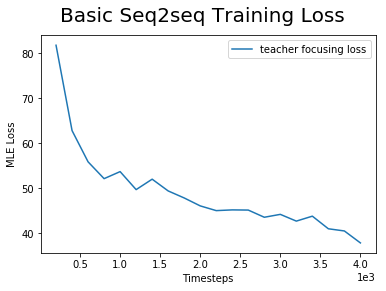

In [7]:
import matplotlib.pyplot as plt
log_t = log_data['t']
log_loss = log_data['loss']
log_plot= plt.figure()
plt.plot(log_t, log_loss, label='teacher focusing loss')
plt.suptitle('Basic Seq2seq Training Loss', fontsize=20)
plt.xlabel('Timesteps')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('MLE Loss')
plt.legend()
plt.show()

## Evaluation
we use MLE loss and BLEU score(http://aclweb.org/anthology/P/P02/P02-1040.pdf) to evaluate.

At training time, the decode mode is teacher focusing, while at test time, the decode mode is free running. Thus, the MLE loss is supposed to be much higher than it at training time.

In [9]:
import bleu
def eval(gen_config):
    vocab, rev_vocab, dev_set, train_set = data_utils.prepare_data(gen_config)
    for b_set in dev_set:
        print("b_set: ", len(b_set))

    with tf.Session() as sess:
        model = Seq2SeqModel(gen_config, name_scope="Basic_Seq2seq", forward_only=True,
                                            dtype=tf.float32)
        gen_ckpt_dir = os.path.abspath(os.path.join(gen_config.save_dir, "checkpoints"))
        ckpt = tf.train.get_checkpoint_state(gen_ckpt_dir)
        if ckpt and tf.train.checkpoint_exists(ckpt.model_checkpoint_path):
            #print("Reading Gen model parameters from %s" % ckpt.model_checkpoint_path)
            model.saver.restore(sess, ckpt.model_checkpoint_path)
        else: 
            raise ValueError("Please run the training first")
        # Run evals on development set and print their perplexity.
        for bucket_id in xrange(len(gen_config.buckets)):
            encoder_inputs, decoder_inputs, target_weights, inputs_len, target_len = \
                    data_utils.get_batch(gen_config, dev_set, bucket_id)
            _, eval_loss, sample_ids = model.step(sess, encoder_inputs, decoder_inputs, 
                                        target_weights, inputs_len, target_len, bucket_id, True)
            eval_ppx = math.exp(eval_loss) if eval_loss < 300 else float('inf')
            print("eval: bucket %d loss %.4f perplexity %.2e" % (bucket_id, eval_loss, eval_ppx))
            # process the output for better demonstration.
            queries = data_utils.clean(encoder_inputs, data_utils.PAD_ID)
            answers = data_utils.clean(decoder_inputs[1:], data_utils.EOS_ID)
            gens = data_utils.clean(sample_ids, data_utils.EOS_ID)
            references = [[gen] for gen in gens]
            # compute four BLEU score
            for i in range(4):
                bleu_score, _, _, _, _, _ = bleu.compute_bleu(references, answers, max_order = i+1)
                print("BLEU %d sorces: %.4f"%(i+1, 100 * bleu_score))
            for i in range(3):
                print("Q:", " ".join([tf.compat.as_str(rev_vocab[j]) for j in queries[i]]))
                print("A:", " ".join([tf.compat.as_str(rev_vocab[j]) for j in answers[i]]))
                print("G:", " ".join([tf.compat.as_str(rev_vocab[j]) for j in gens[i]]))
                bleu_score, _, _, _, _, _ = bleu.compute_bleu([[gens[i]]], [answers[i]], max_order = 1)
                print("BLEU sorces: %.4f"%(100 * bleu_score))
                print()

Let's see the result: I eval different bucket([(5, 10), (10, 15), (20, 25), (40, 50)]) in the test data.
I also show some demonstration during evaluation: 
Q is the quary, A is the real answer in the test data, G is the generated answer by our bot.

In [7]:
with tf.Graph().as_default():
    eval(gen_config)

Reading development and training gen_data
b_set:  133
b_set:  1427
b_set:  3007
b_set:  1826
INFO:tensorflow:Restoring parameters from /home/chenminghao/git_work/Chatbot_test/log/gen_models/checkpoints/gen.model-4000
eval: bucket 0 loss 62.4131 perplexity 1.28e+27
BLEU 1 sorces: 11.0192
BLEU 2 sorces: 3.7036
BLEU 3 sorces: 1.4920
BLEU 4 sorces: 0.0000
Q: _UNK dollars
A: here you are .
G: i ' m afraid not .
BLEU sorces: 15.1633

Q: it was funny .
A: tell me about it , will you ?
G: i ' m glad you like it .
BLEU sorces: 25.0000

Q: that is 0-0-0 ?
A: no , that ' s 0-0 .
G: yes , it ' s a very good time .
BLEU sorces: 37.2251

eval: bucket 1 loss 84.1989 perplexity 3.69e+36
BLEU 1 sorces: 19.0895
BLEU 2 sorces: 7.7853
BLEU 3 sorces: 4.0111
BLEU 4 sorces: 2.0204
Q: do you have a free moment ?
A: sure . what do you need ?
G: yes , i have a few days .
BLEU sorces: 12.3840

Q: it happened at my house .
A: was anything stolen ?
G: i ' m sorry , sir . i ' ll have to get you in
BLEU sorces: 0.00

## Conclusion
As we can see from the demonstration, the neural network has learn the language model very well and it is trying to answer the question: for example, Q: do you have a free moment ? G: yes , i have a few days . the bot has awared that it should answer yes or no and say something about it own time. We only use basic Seq2seq and train it only 4000 steps. It is a little incredible to see the nice result.

However, we can see that BLEU score is no high and the bot always say some common things: i ' m sorry; i ' ve heard that. and the bot can't answer a little difficult question: Q: who is he marring ? G: he ' s a very good guy .

Thus, the bot can't understand (recognize the pattern in language) complex sentence (for example, he can't spot the relation between the weather report and TV).

We have to train more steps, tune the parameters, and use more advance model to deal with the problem. In next notebook, we hope we can do better.

**Now, let's try the movie data**

You can download it at http://www.cs.cornell.edu/~cristian/Cornell_Movie-Dialogs_Corpus.html

Rename the train_data and dev_data as 'chat.in' and 'chat_test.in', and place them at 'movie_data'.

In [11]:
gen_config.train_dir = 'movie_data'
gen_config.save_dir = 'log/movie_gen_models'
#prepare the movie_data
vocab, rev_vocab, dev_set, train_set = data_utils.prepare_data(gen_config)

Reading development and training gen_data
  reading data line 100000
  reading data line 200000


In [6]:
gen_config.pretrain_steps = 8000
gen_config.steps_per_checkpoint = 500
with tf.Graph().as_default():
    log_data = train(gen_config)

Reading development and training gen_data
  reading data line 100000
  reading data line 200000
b_set:  17348
b_set:  53076
b_set:  74236
b_set:  57741
Creating 1 layers of 128 units.
creat gen_model time: 1.459
Begin training...
Record every 500 steps
 step:  500  step_loss: 44.8226 step_time:  0.1116 bucket:2 
 global step 500 learning rate 0.5000 step-time 0.12 loss 63.3052 perplexity 3.11e+27
 step: 1000  step_loss: 45.1348 step_time:  0.1099 bucket:2 
 global step 1000 learning rate 0.5000 step-time 0.12 loss 51.3296 perplexity 1.96e+22
 step: 1500  step_loss: 26.7986 step_time:  0.0704 bucket:1 
 global step 1500 learning rate 0.5000 step-time 0.13 loss 49.1661 perplexity 2.25e+21
 step: 2000  step_loss: 42.6318 step_time:  0.1101 bucket:2 
 global step 2000 learning rate 0.5000 step-time 0.13 loss 48.2005 perplexity 8.57e+20
 step: 2500  step_loss: 44.6767 step_time:  0.1136 bucket:2 
 global step 2500 learning rate 0.5000 step-time 0.12 loss 45.8265 perplexity 7.98e+19
 step: 3

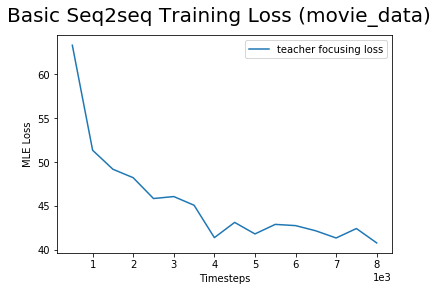

In [7]:
import matplotlib.pyplot as plt
log_t = log_data['t']
log_loss = log_data['loss']
log_plot= plt.figure()
plt.plot(log_t, log_loss, label='teacher focusing loss')
plt.suptitle('Basic Seq2seq Training Loss (movie_data)', fontsize=20)
plt.xlabel('Timesteps')
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.ylabel('MLE Loss')
plt.legend()
plt.show()

In [10]:
with tf.Graph().as_default():
    eval(gen_config)

Reading development and training gen_data
  reading data line 100000
  reading data line 200000
b_set:  422
b_set:  1065
b_set:  1742
b_set:  1409
INFO:tensorflow:Restoring parameters from /home/chenminghao/git_work/Chatbot_test/log/movie_gen_models/checkpoints/gen.model-8000
eval: bucket 0 loss 54.1671 perplexity 3.35e+23
BLEU 1 sorces: 4.3951
BLEU 2 sorces: 2.0357
BLEU 3 sorces: 1.1812
BLEU 4 sorces: 0.6903
Q: in there .
A: show me .
G: i ' m sorry , i didn ' t want
BLEU sorces: 0.0000

Q: no .
A: why not ?
G: i ' m sorry , i didn ' t want
BLEU sorces: 0.0000

Q: maestro .
A: good morning .
G: i ' m sorry , i didn ' t want
BLEU sorces: 0.0000

eval: bucket 1 loss 75.4207 perplexity 5.69e+32
BLEU 1 sorces: 8.3771
BLEU 2 sorces: 3.6706
BLEU 3 sorces: 1.9223
BLEU 4 sorces: 1.1393
Q: which one pulled the trigger ?
A: the indian . i was about 30 yards away .
G: i don ' t know .
BLEU sorces: 20.0000

Q: did you like it , then ?
A: how could i not ?
G: i didn ' t know what you said , but i 

All right, movie data is more noise and may need preprocess and much more training. The bot is kind of afraid of make mistake and confused by the noisy data, so it always say: i ' m sorry. i don ' t know .

These dull answer are also needed to be solved.